In [1]:
# Import necessary libraries
import pandas as pd
from datetime import datetime as dt
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load data and print its shape

directory = "se94"

# Train data
train = pd.read_csv(f"data/{directory}/train.csv")

# Test data 
test = pd.read_csv(f"data/{directory}/test.csv")

# Print shape
print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (100000, 16)
test: (25000, 16)


In [3]:
# Drop unnecessary columns
def drop_unnecessary_columns(data, columns):
    return data.drop(columns, axis=1)

columns_to_drop = ["message_id", "reply_to_id", "text", "forwarded_from", "caption", "media_size",
                   "photo_resolution", "media_duration", "sticker_emoji"]

train = drop_unnecessary_columns(train, columns_to_drop)
test = drop_unnecessary_columns(test, columns_to_drop)

In [4]:
# Extract {day_of_week, day_of_month, hour_of_day, month_of_year} from message_date and drop message_date
def extract_and_delete(data):
    location = data.columns.get_loc('message_date')
    day_of_week = data["message_date"].apply(lambda x: dt.utcfromtimestamp(x).strftime("%w"))
    data.insert(loc=location, column="day_of_week", value=day_of_week)

    day_of_month = data["message_date"].apply(lambda x: dt.utcfromtimestamp(x).strftime("%d"))
    data.insert(loc=location+1, column="day_of_month", value=day_of_month)

    hour_of_day = data["message_date"].apply(lambda x: dt.utcfromtimestamp(x).strftime("%H"))
    data.insert(loc=location+2, column="hour_of_day", value=hour_of_day)

    month_of_year = data["message_date"].apply(lambda x: dt.utcfromtimestamp(x).strftime("%m"))
    data.insert(loc=location+3, column="month_of_year", value=month_of_year)
    
    return data.drop(['message_date'], axis=1)


train = extract_and_delete(train)
test = extract_and_delete(test)

In [5]:
# Replace text_emojis column with contains_emoji
def contains_emoji(data):
    location = data.columns.get_loc("text_length")
    data.insert(loc=location+1, column="contains_emoji", value=data["text_emojis"].apply(lambda x: 1 if type(x) == str else 0))
    
    return data.drop("text_emojis", axis=1)

train = contains_emoji(train)
test = contains_emoji(test)

In [6]:
# Replace reply_to_sender column with reply_to as reply_to_id doesn't exist no more
def rename_reply_column(data):
    return data.rename(columns={
        "reply_to_sender": "reply_to",
        "message_type": "mt"
    })

train = rename_reply_column(train)
test = rename_reply_column(test)

In [7]:
# Temporarily drop 'reply_to' to bring back later
columns_to_drop = ["reply_to"]

train = drop_unnecessary_columns(train, columns_to_drop)
test = drop_unnecessary_columns(test, columns_to_drop)

In [8]:
# Prepare X, y, and X_test for training and predicting
X = train.iloc[:, 1:]
y = train.iloc[:, 0]

X = pd.get_dummies(X, columns=["mt"])

X_test = test.iloc[:, 1:]
X_test = pd.get_dummies(X_test, columns=["mt"])
y_test = test.iloc[:, 0]

In [9]:
# Create a decision tree and predict for max-depth from 39 to 1

train_scores = [] # classifier scores for train data
test_scores = [] # classifier scores for test data
precisions = []
recalls = []
fmeasures = []

def decision_tree(X, y, X_test, y_test, max_depth=None):
    result = [] # max_depth, train_score, test_score, precision, recall, fmeasure

    # Train
    if max_depth:
        classifier = DecisionTreeClassifier(max_depth=max_depth)
    else:
        classifier = DecisionTreeClassifier()
    
    classifier.fit(X.values, y.values)
    
    result.append(classifier.tree_.max_depth) # first element of return list

    train_score = classifier.score(X, y)
    result.append(round(train_score*100, 2)) # second element of return list 

    # Predict
    y_predicted = classifier.predict(X_test)

    # Evaluate
    test_score = classifier.score(X_test, y_test)
    result.append(round(test_score*100, 2)) # third element of return list
    
    precision = metrics.precision_score(y_test, y_predicted, average='micro')
    result.append(round(precision*100, 2)) # fourth element of return list 
    
    recall = metrics.recall_score(y_test, y_predicted, average='micro')
    result.append(round(recall*100, 2)) # fifth element of return list
    
    fmeasure = metrics.f1_score(y_test, y_predicted, average='micro')
    result.append(round(fmeasure*100, 2)) # sixth element of return list
    
    return result

# _d is short for _default
max_depth_d, train_score_d, test_score_d, precision_d, recall_d, fmeasure_d = decision_tree(X, y, X_test, y_test)

for i in range(max_depth_d, 0, -1):
    max_depth, train_score, test_score, precision, recall, fmeasure = decision_tree(X, y, X_test, y_test, i)
    train_scores.append(train_score)
    test_scores.append(test_score)
    precisions.append(precision)
    recalls.append(recall)
    fmeasures.append(fmeasure)
    print(i, end=' ')

39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 

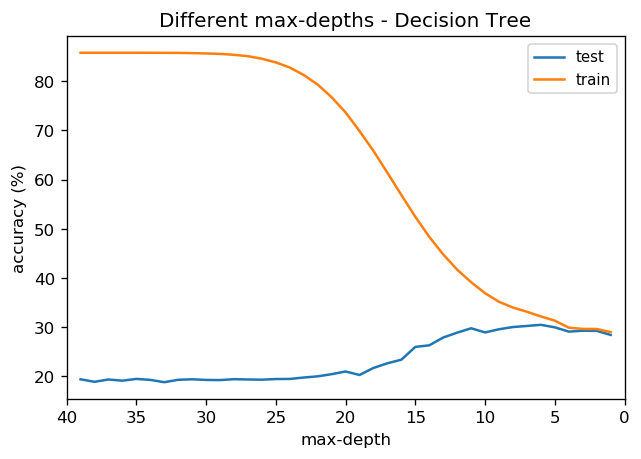

In [10]:
# Plot accuracy for train and test
plt.figure(dpi=120)
plt.plot(range(max_depth_d, 0, -1), test_scores, label="test")
plt.plot(range(max_depth_d, 0, -1), train_scores, label="train")
plt.title("Different max-depths - Decision Tree")
plt.legend(prop={"size": 9})

ax = plt.gca()
ax.set_xlim(max_depth_d+1, 0)
ax.set_xlabel("max-depth")
ax.set_ylabel("accuracy (%)")

plt.savefig(f"output/{directory}/Accuracy for different max-depths - Decision Tree", dpi=500)
plt.show()

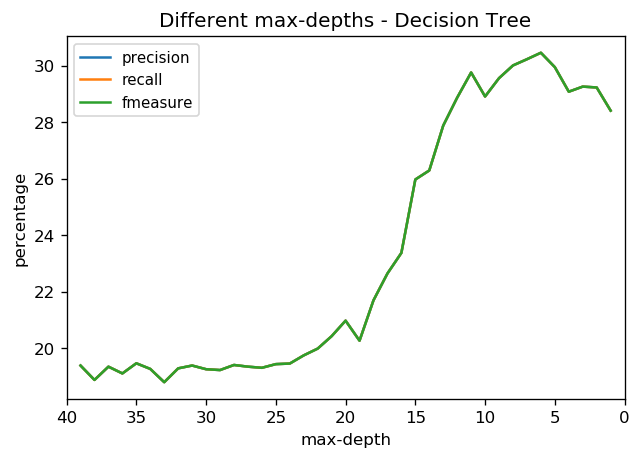

In [11]:
# Plot Precision, Recall, and Fmeasure
plt.figure(dpi=120)
plt.plot(range(max_depth_d, 0, -1), precisions, label="precision")
plt.plot(range(max_depth_d, 0, -1), recalls, label="recall")
plt.plot(range(max_depth_d, 0, -1), fmeasures, label='fmeasure')

plt.title("Different max-depths - Decision Tree")
plt.legend(prop={"size": 9})

ax = plt.gca()
ax.set_xlim(max_depth_d+1, 0)
ax.set_xlabel('max-depth')
ax.set_ylabel('percentage')

plt.savefig(f"output/{directory}/Precision, Recall, Fmeasure for different max-depths - Decision Tree", dpi=500)
plt.show()